Notebook that computes features and labels on completed vacuum relative FEP runs on the FreeSolv database.


In [1]:
#import pymbar
import hydra_utils
import hydra_labels
import glob
import matplotlib.pyplot as plt
import pandas as pd

#import seaborn as sns 
from tqdm.notebook import tqdm
from IPython.display import Image, display, Math

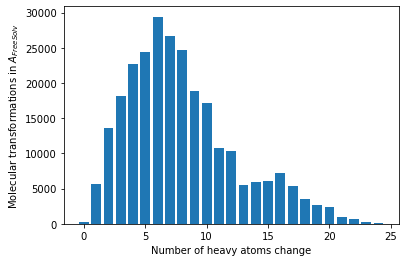

In [2]:
num_per_transform_df = pd.read_csv("/home/jscheen/projects/NxN-FREESOLV/SOLV/FREESOLV/jobs/01_PREPARE_DATASTUCTURES/02_SUBSETS_transforms/num_per_transform.csv", header=None)

num_per_transform_df[0] = [ int(transf.replace("transform_", "")) for transf in num_per_transform_df[0].values.tolist() ]
num_per_transform_df = num_per_transform_df.sort_values(by=[0])

plt.bar(num_per_transform_df[0], num_per_transform_df[1])
plt.ticklabel_format(style='sci', axis='y')
plt.ylabel("Molecular transformations in $A_{FreeSolv}$")
plt.xlabel("Number of heavy atoms change")
plt.savefig("output/NxN_overview.png", dpi=300)

Dropped 14084 NaN rows (29489 total).


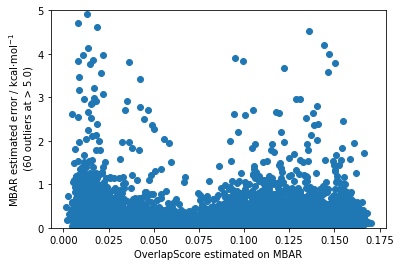

In [3]:
trainset_df = pd.read_csv("labels/mbar_labels.txt", header=None)
trainset_df.columns=["pert", "error", "freenrg", "OS"]

trainset_precise = trainset_df.dropna()
print("Dropped", len(trainset_df)-len(trainset_precise), "NaN rows ("+str(len(trainset_df))+" total).")
plt.scatter(trainset_precise["OS"], trainset_precise["error"])

error_outliers = len(trainset_precise[trainset_precise["error"] > 5])

plt.ylim(0, 5)
plt.ylabel("MBAR estimated error / kcal$\cdot$mol$^{-1}$ \n ("+str(error_outliers)+" outliers at > 5.0)")
plt.xlabel("OverlapScore estimated on MBAR")


plt.show()

## 1. Explore input data

In [4]:
simulated_contents = glob.glob("SOLVATED/*")
num_simulated_contents = len(simulated_contents)
print(num_simulated_contents, "completed runs in database.")

29489 completed runs in database.


In [5]:
errors_all = []
error_paths = []
ovlp_matx_all = []
ovlp_matx_paths = []
for path in tqdm(simulated_contents):
    path += "/free/freenrg-MBAR.dat"
    (ovlp_matx, freenrg, error) = hydra_labels.retrieveMBAROutput(path)
    
    if ovlp_matx is not None:        
        if ovlp_matx != "None":
            ovlp_matx_all.append(ovlp_matx)
            ovlp_matx_paths.append(path)
    if error:        
        if error != "None":
            error = float(error)
            errors_all.append(error)
            error_paths.append(path)
        
# exclude absurdly high errors:
print(len(errors_all))
errors = [error for error in errors_all if error < 10]              
        
num_errors = len(errors)
perc_errors = round(num_errors/num_simulated_contents*100)
print(num_errors, "collected MBAR errors ("+str(perc_errors)+"%).")


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [ ]:
ax_errors = sns.kdeplot(errors)
ax_errors.set_title("Solvated MBAR errors on "+str(num_errors)+" relative \n FEP calculations on FreeSolv")
ax_errors.set_ylabel("Density / A.U.")
ax_errors.set_xlabel(r"MBAR estimator error / kcal$\cdot$mol$^{-1}$")
ax_errors.set_xlim(0,2)
plt.show()

### Check if absurd errors are coupled to absurd perturbations:

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
num_to_depict = 20

In [ ]:
# zip the errors to the paths:
errors_zipped = list(zip(error_paths, errors_all))
# exclude perts where error = 0.0:
errors_filtered = [tup for tup in errors_zipped if tup[1] > 0.005]



worst_perts = sorted(errors_zipped, key=lambda tup: tup[1])[-num_to_depict:]
best_perts = sorted(errors_filtered, key=lambda tup: tup[1])[:num_to_depict]
nought_perts = [tup for tup in errors_zipped if tup[1] == 0][:num_to_depict]

#### Worst errors:

In [ ]:
mols_to_depict = []
for pert in worst_perts:
    ligA_path = "FREESOLV/"+pert[0].split("/")[1].split("~")[0]+".pdb"
    ligB_path = "FREESOLV/"+pert[0].split("/")[1].split("~")[1]+".pdb"
    ligA = hydra_utils.retrieveMolecule(ligA_path)
    ligB = hydra_utils.retrieveMolecule(ligB_path)
    AllChem.Compute2DCoords(ligA)
    AllChem.Compute2DCoords(ligB)
    mols_to_depict.append(ligA)
    mols_to_depict.append(ligB)
Draw.MolsToGridImage(mols_to_depict, molsPerRow=2)
 

### Best errors:

In [ ]:
mols_to_depict = []

for pert in best_perts:
    ligA_path = "FREESOLV/"+pert[0].split("/")[1].split("~")[0]+".pdb"
    ligB_path = "FREESOLV/"+pert[0].split("/")[1].split("~")[1]+".pdb"
    ligA = hydra_utils.retrieveMolecule(ligA_path)
    ligB = hydra_utils.retrieveMolecule(ligB_path)
    AllChem.Compute2DCoords(ligA)
    AllChem.Compute2DCoords(ligB)
    mols_to_depict.append(ligA)
    mols_to_depict.append(ligB)
Draw.MolsToGridImage(mols_to_depict, molsPerRow=2)

### Nought errors:
#### We expect these to be unrealistic as well

In [ ]:
mols_to_depict = []
for pert in nought_perts:
    ligA_path = "FREESOLV/"+pert[0].split("/")[1].split("~")[0]+".pdb"
    ligB_path = "FREESOLV/"+pert[0].split("/")[1].split("~")[1]+".pdb"
    ligA = hydra_utils.retrieveMolecule(ligA_path)
    ligB = hydra_utils.retrieveMolecule(ligB_path)
    AllChem.Compute2DCoords(ligA)
    AllChem.Compute2DCoords(ligB)
    mols_to_depict.append(ligA)
    mols_to_depict.append(ligB)
if len(mols_to_depict) > 0:
    Draw.MolsToGridImage(mols_to_depict, molsPerRow=2)
else:
    print("No nought errors present.")

## Overlap matrix heuristic 

In [6]:
import random
# pick 5 random matrices for easier testing:
ovlp_matx_selection = random.sample(ovlp_matx_all, 50)

ValueError: Sample larger than population or is negative

In [ ]:
import seaborn as sns
display(Math(r"OverlapScore = \frac{\langle Overlap_{\vec{\lambda}} \rangle}{|violations|+1} "))
for matrix in ovlp_matx_selection:
    
    off_diag_overlaps= []
    for lambda_idx, matrix_row in zip(range(10), matrix):
        off_diag_overlap = matrix_row[lambda_idx + 1]
        off_diag_overlaps.append(off_diag_overlap)
    
    mean_overlap = np.mean(off_diag_overlaps)
    # we're interested in consistency of the off-diagonal vector; but also in dips in overlap;
    # as such, count number of overlap values that fall on or below the recommended 0.03:
    low_overlaps = [val for val in off_diag_overlaps if val < 0.03]
    num_low_overlaps = len(low_overlaps)


    OS = mean_overlap/(num_low_overlaps+1)

    plt.figure(figsize=(10,7))
    sns.heatmap(matrix, annot=True)
    plt.title("OS: "+str(OS))
    plt.show()

## Analyse first round of DNN validation set

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

dnn_molprops_validation = pd.read_csv("output/MOLPROPS_top_performer.csv")
print("Number of test points:", len(dnn_molprops_validation))

Number of test points: 2097


In [11]:
from scipy import stats
from sklearn.metrics import mean_absolute_error


def computeStats(x_vector, y_vector):
    pearsonr = round(stats.pearsonr(x_vector, y_vector)[0], 3)
    tau = round(stats.kendalltau(x_vector, y_vector)[0], 3)
    #rho = round(stats.spearmanr(x_vector, y_vector[0]), 3)
    mae = round(mean_absolute_error(x_vector, y_vector), 3)

    return pearsonr, tau, mae

<IPython.core.display.Math object>

/home/jscheen/miniconda3/envs/TSFLW/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  # This is added back by InteractiveShellApp.init_path()


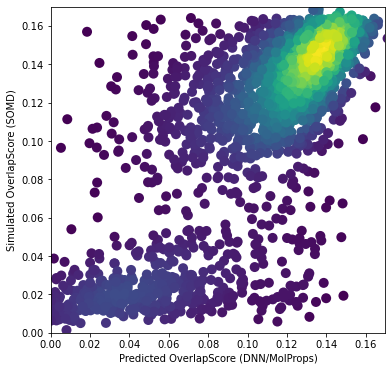

       Pearson r  Kendall tau    MAE
Value      0.761        0.545  0.024


In [23]:
x = dnn_molprops_validation["Pred1"]
y = dnn_molprops_validation["Exp1"]
display(Math(r"OverlapScore = \frac{\langle Overlap_{\vec{\lambda}} \rangle}{|violations|+1} "))
# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)


plt.figure(figsize=(6,6))

plt.scatter(x, y, c=z, s=100, edgecolor='')
plt.xlim(0, 0.17)
plt.ylim(0, 0.17)
plt.xlabel("Predicted OverlapScore (DNN/MolProps)")
plt.ylabel("Simulated OverlapScore (SOMD)")
plt.show()
stat_measures = computeStats(x.values, y.values)
print(pd.DataFrame.from_dict({"Value" : stat_measures}, orient="index", columns=["Pearson r", "Kendall tau", "MAE"]))

SKOPT hyperparameter convergence plot:

In [ ]:
skopt_csv = pd.read_csv("output/PFP_skopt_conv_data.csv", error_bad_lines=False, names=["MAE", "Tau"])
# remove any nan values manually

mae_values = np.minimum.accumulate(skopt_csv["MAE"].values)
tau_values = np.maximum.accumulate(skopt_csv["Tau"].values)

x_index = np.array(range(len(mae_values)))
plt.plot(x_index, mae_values, color="darkorange")
plt.xlabel("SKOPT calls")
plt.ylabel("MAE / kcal$\cdot$mol$^{-1}$")
plt.show()
plt.plot(x_index, tau_values, color="navy")
plt.xlabel("SKOPT calls")
plt.ylabel("Kendall tau on test set")
plt.show()